In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

In [ ]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=22)
rc('axes', labelsize=28)

In [3]:
# CSV functions
def csv_to_dict(file):
    """
    read CSV file and create dict with key for each head containing a list of column entries for respective head
    
    :param file: path to CSV file to read
    :return: created dictionary
    """
    d = {}
    with open(file) as fin:
        reader = csv.reader(fin)
        headers = next(reader, None)
        for h in headers:
            d[h] = []
        for row in reader:
            for h, entry in zip(headers,row):
                d[h].append(entry)
    return d


def print_csv_dict(d):
    """
    print CSV dictionary in formatted way
    
    :param d: dict of CSV file to print
    :return:
    """
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(d)

In [4]:
# IMU data dict functions
def extract_acc(d):
    """
    extract acceleration vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: a (numpy array)
    """
    a = np.array(d['a'], dtype='float32')
    return a

def extract_z(d):
    """
    extract acceleration measurements for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: z (numpy array)
    """
    z = np.array(d['z'], dtype='float32')
    return z

def extract_vel(d):
    """
    extract velocity vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: v (numpy array)
    """
    v = np.array(d['v'], dtype='float32')
    return v

def extract_pos(d):
    """
    extract position vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: p (numpy array)
    """
    p = np.array(d['d'], dtype='float32')
    return p

def extract_time(d):
    """
    extract time vector for IMU data run dict (in seconds)
    
    :param d: dict of CSV file of IMU data run
    :return: time
    """
    timestamps = np.array(d['t'], dtype='float32')
    return timestamps

In [5]:
def extract_param(file_name, param):
    """
    Extract param value from file name
    :param file_name: name of file
    :param param: name of parameter in file
    """
    if  file_name.startswith("default"):
        if param == "initialVar":
            return 0.5
        elif param == "stateVar":
            return 0.02
        elif param == "measVar":
            return 0.001
        else:
            raise ValueError("Unknown parameter %s!" % param)
    assert(file_name.startswith(param))
    value_string = file_name[len(param):].split("_")[0]
    
    if value_string[0] == "0":
        value = float("0." + value_string[1:])
    else:
        value = float(value_string)
    return value

In [10]:
# read all data files for stationary test
initial_var_dicts = {} 
for file in os.listdir("stationary/initial_error_variance"):
    if not file.endswith(".csv"):
        continue
    data_file = os.path.join("stationary/initial_error_variance", file) 
    param = extract_param(file, "initialVar")
    if param not in initial_var_dicts:
        initial_var_dicts[param] = [csv_to_dict(data_file)]
    else:
        initial_var_dicts[param].append(csv_to_dict(data_file))
    
state_var_dicts = {} 
for file in os.listdir("stationary/state_transition_variance"):
    if not file.endswith(".csv"):
        continue
    data_file = os.path.join("stationary/state_transition_variance", file) 
    param = extract_param(file, "stateVar")
    if param not in state_var_dicts:
        state_var_dicts[param] = [csv_to_dict(data_file)]
    else:
        state_var_dicts[param].append(csv_to_dict(data_file))
    
measurement_var_dicts = {} 
for file in os.listdir("stationary/measurement_variance"):
    if not file.endswith(".csv"):
        continue
    data_file = os.path.join("stationary/measurement_variance", file) 
    param = extract_param(file, "measVar")
    if param not in measurement_var_dicts:
        measurement_var_dicts[param] = [csv_to_dict(data_file)]
    else:
        measurement_var_dicts[param].append(csv_to_dict(data_file))

In [12]:
# check read values and that always both CSV dicts were read
print("initial vars")
for key in initial_var_dicts:
    print(key, len(initial_var_dicts[key]))
print("state vars:")
for key in state_var_dicts:
    print(key, len(state_var_dicts[key]))
print("measurement vars:")
for key in measurement_var_dicts:
    print(key, len(measurement_var_dicts[key]))

initial vars
0.5 2
0.01 2
0.1 2
10.0 2
5.0 2
state vars:
0.02 2
0.0002 2
0.002 2
0.05 2
0.2 2
measurement vars:
0.001 2
0.0001 2
0.01 2
0.1 2


In [51]:
def generate_plots(param_dict, param_name):
    num_params = len(param_dict.keys())
    num_logs = 2
    
    fig, axs = plt.subplots(num_params * 3, num_logs, figsize=(16,36))
    fig.suptitle("Acceleration Filtering Parameterisation %s" % param_name, y=1.01)
    # plot
    for i, param in enumerate(sorted(param_dict)):
        param_list = param_dict[param]
        for j, d in enumerate(param_list):
            acc = extract_acc(d)
            z = extract_z(d)
            times = extract_time(d)
            axs[i * 3, j].plot(times, z, alpha=0.3, label=r"unfiltered")
            axs[i * 3, j].plot(times, acc, alpha=0.3, label=r"filtered")
            # format
            axs[i * 3, j].set_title(r"%s = %.4f, log %d" % (param_name, param, j + 1))
            if j == 0:
                axs[i * 3, j].set_ylabel(r"$acc$ $[ms^{-2}]$")
            axs[i * 3, j].legend()
            
            # plot vel
            vel = extract_vel(d)
            axs[i * 3 + 1, j].plot(times, vel)
            if j == 0:
                axs[i * 3 + 1, j].set_ylabel(r"$vel$ $[m/s]$")

            # plot pos 
            pos = extract_pos(d)
            axs[i * 3 + 2, j].plot(times, pos)
            if j == 0:
                axs[i * 3 + 2, j].set_ylabel(r"$pos$ $[m]$")
            if i == num_params - 1:
                axs[i * 3 + 2, j].set_xlabel(r"$t$ $[s]$")
    fig.tight_layout()

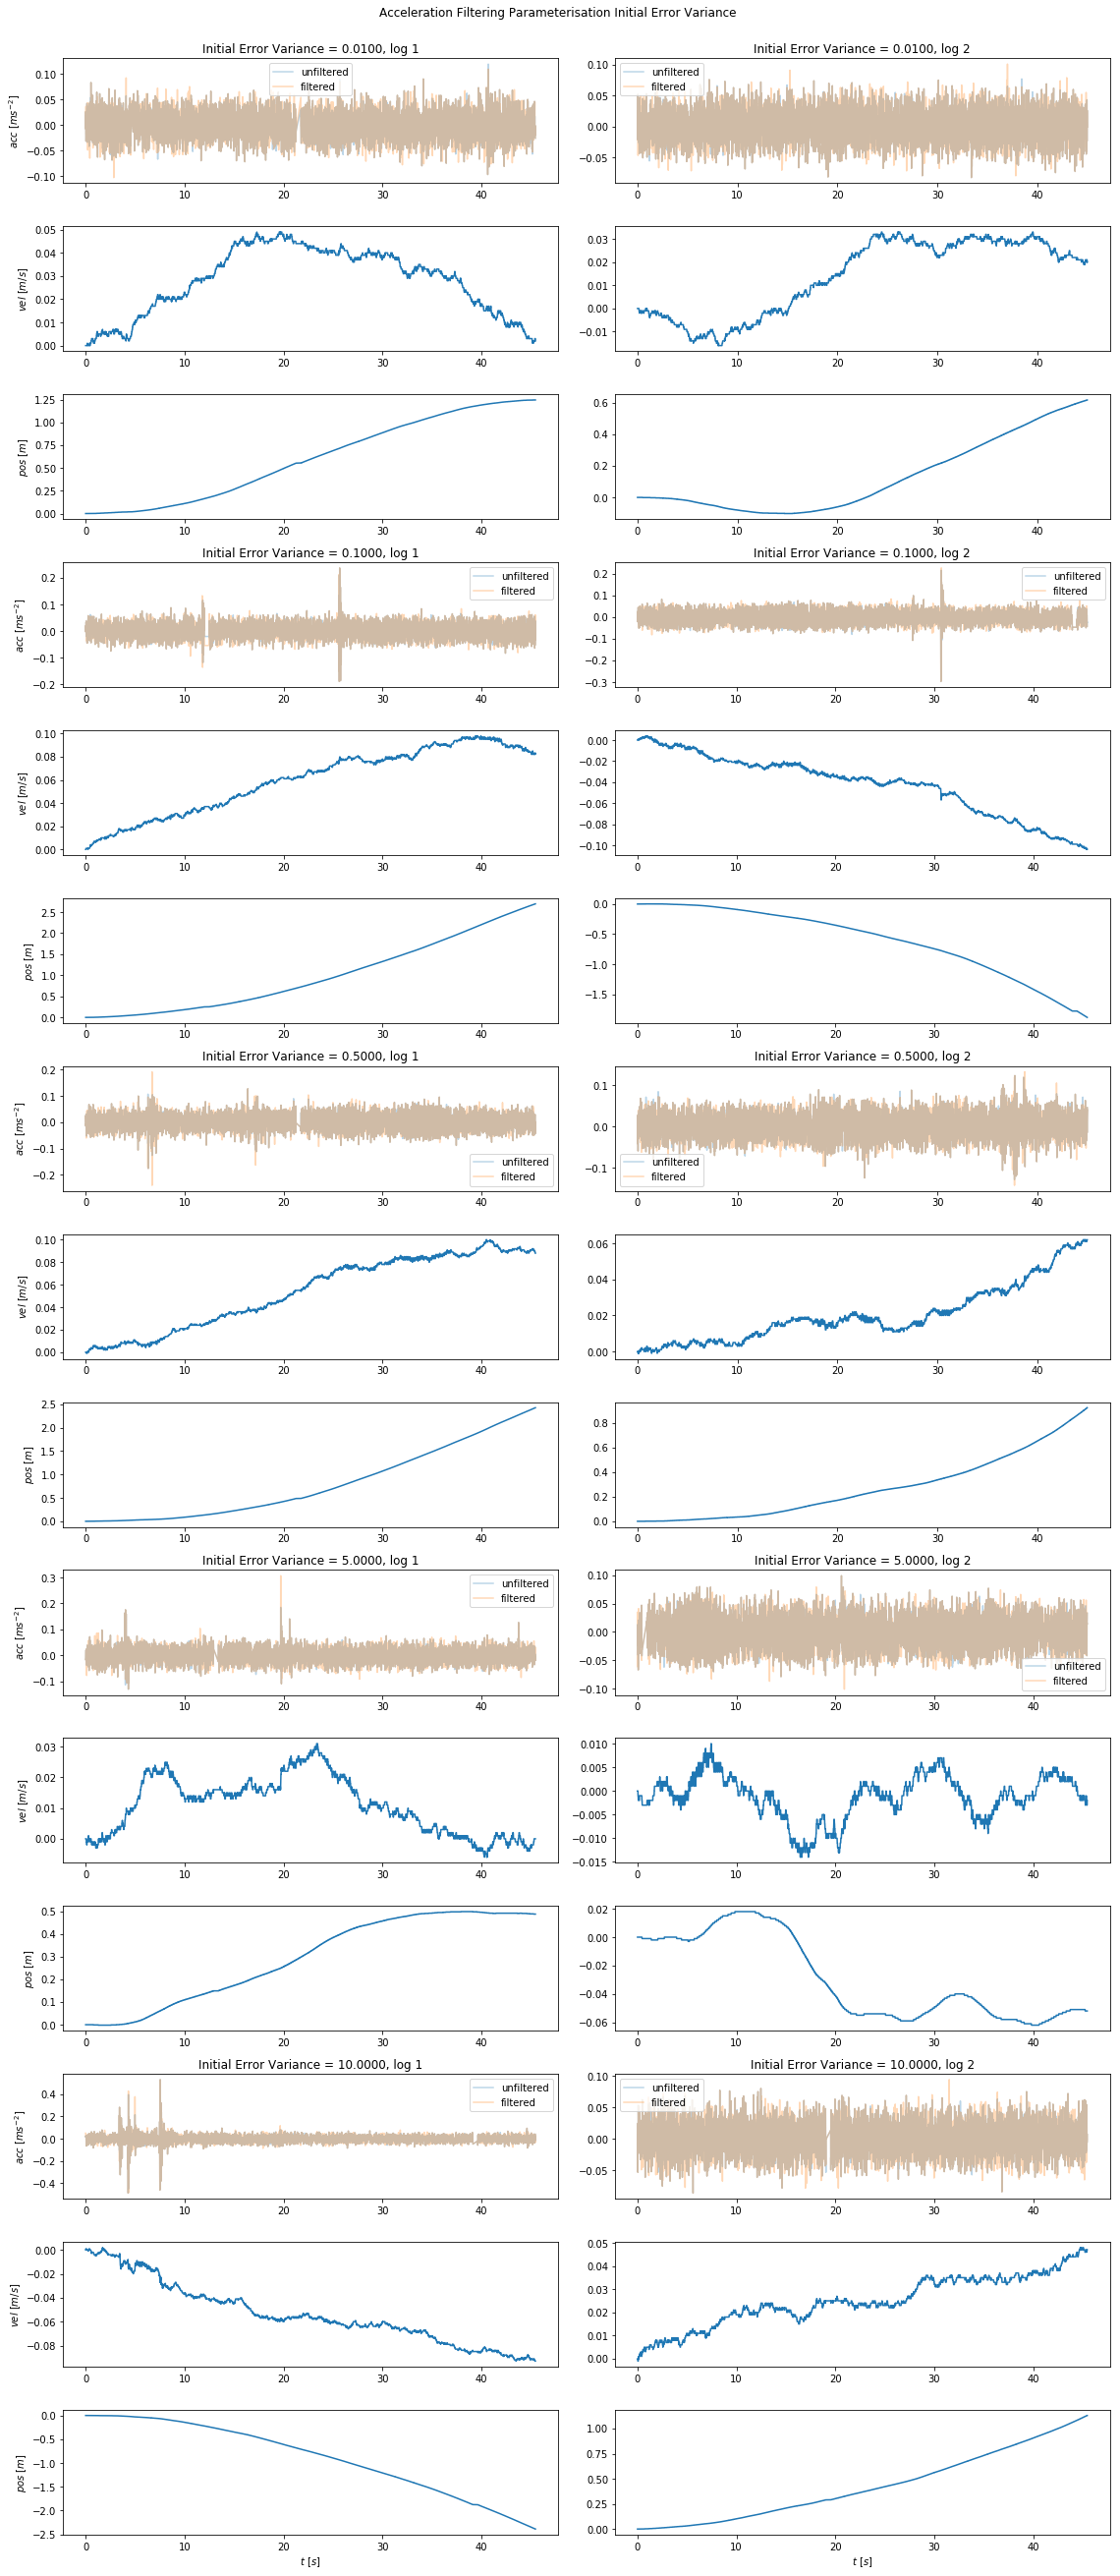

In [52]:
generate_plots(initial_var_dicts, "Initial Error Variance")

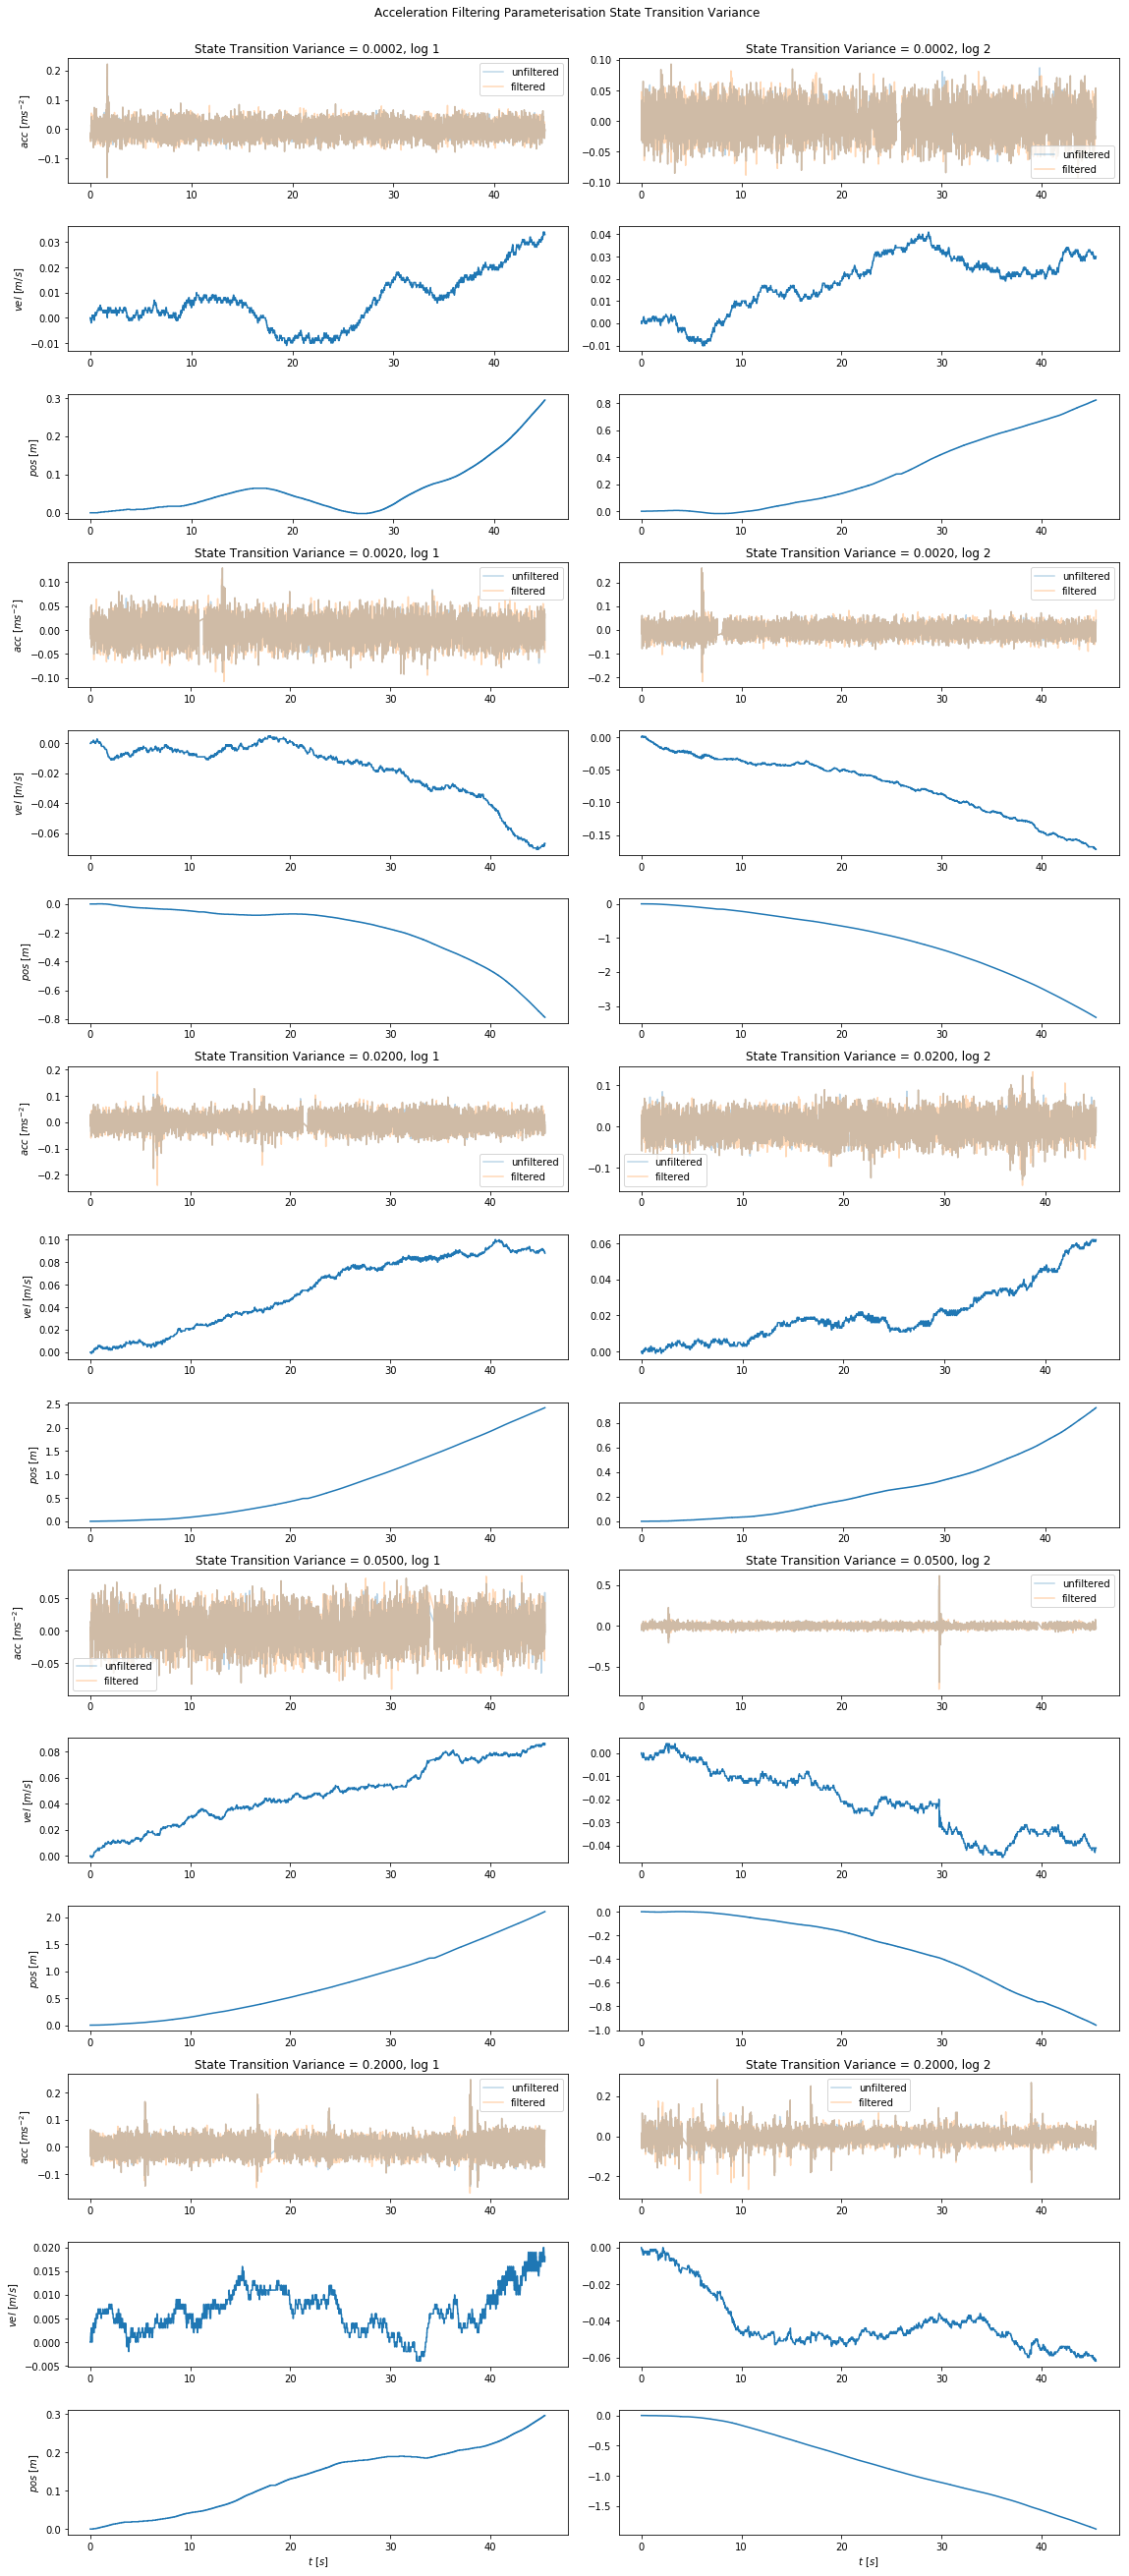

In [53]:
generate_plots(state_var_dicts, "State Transition Variance")

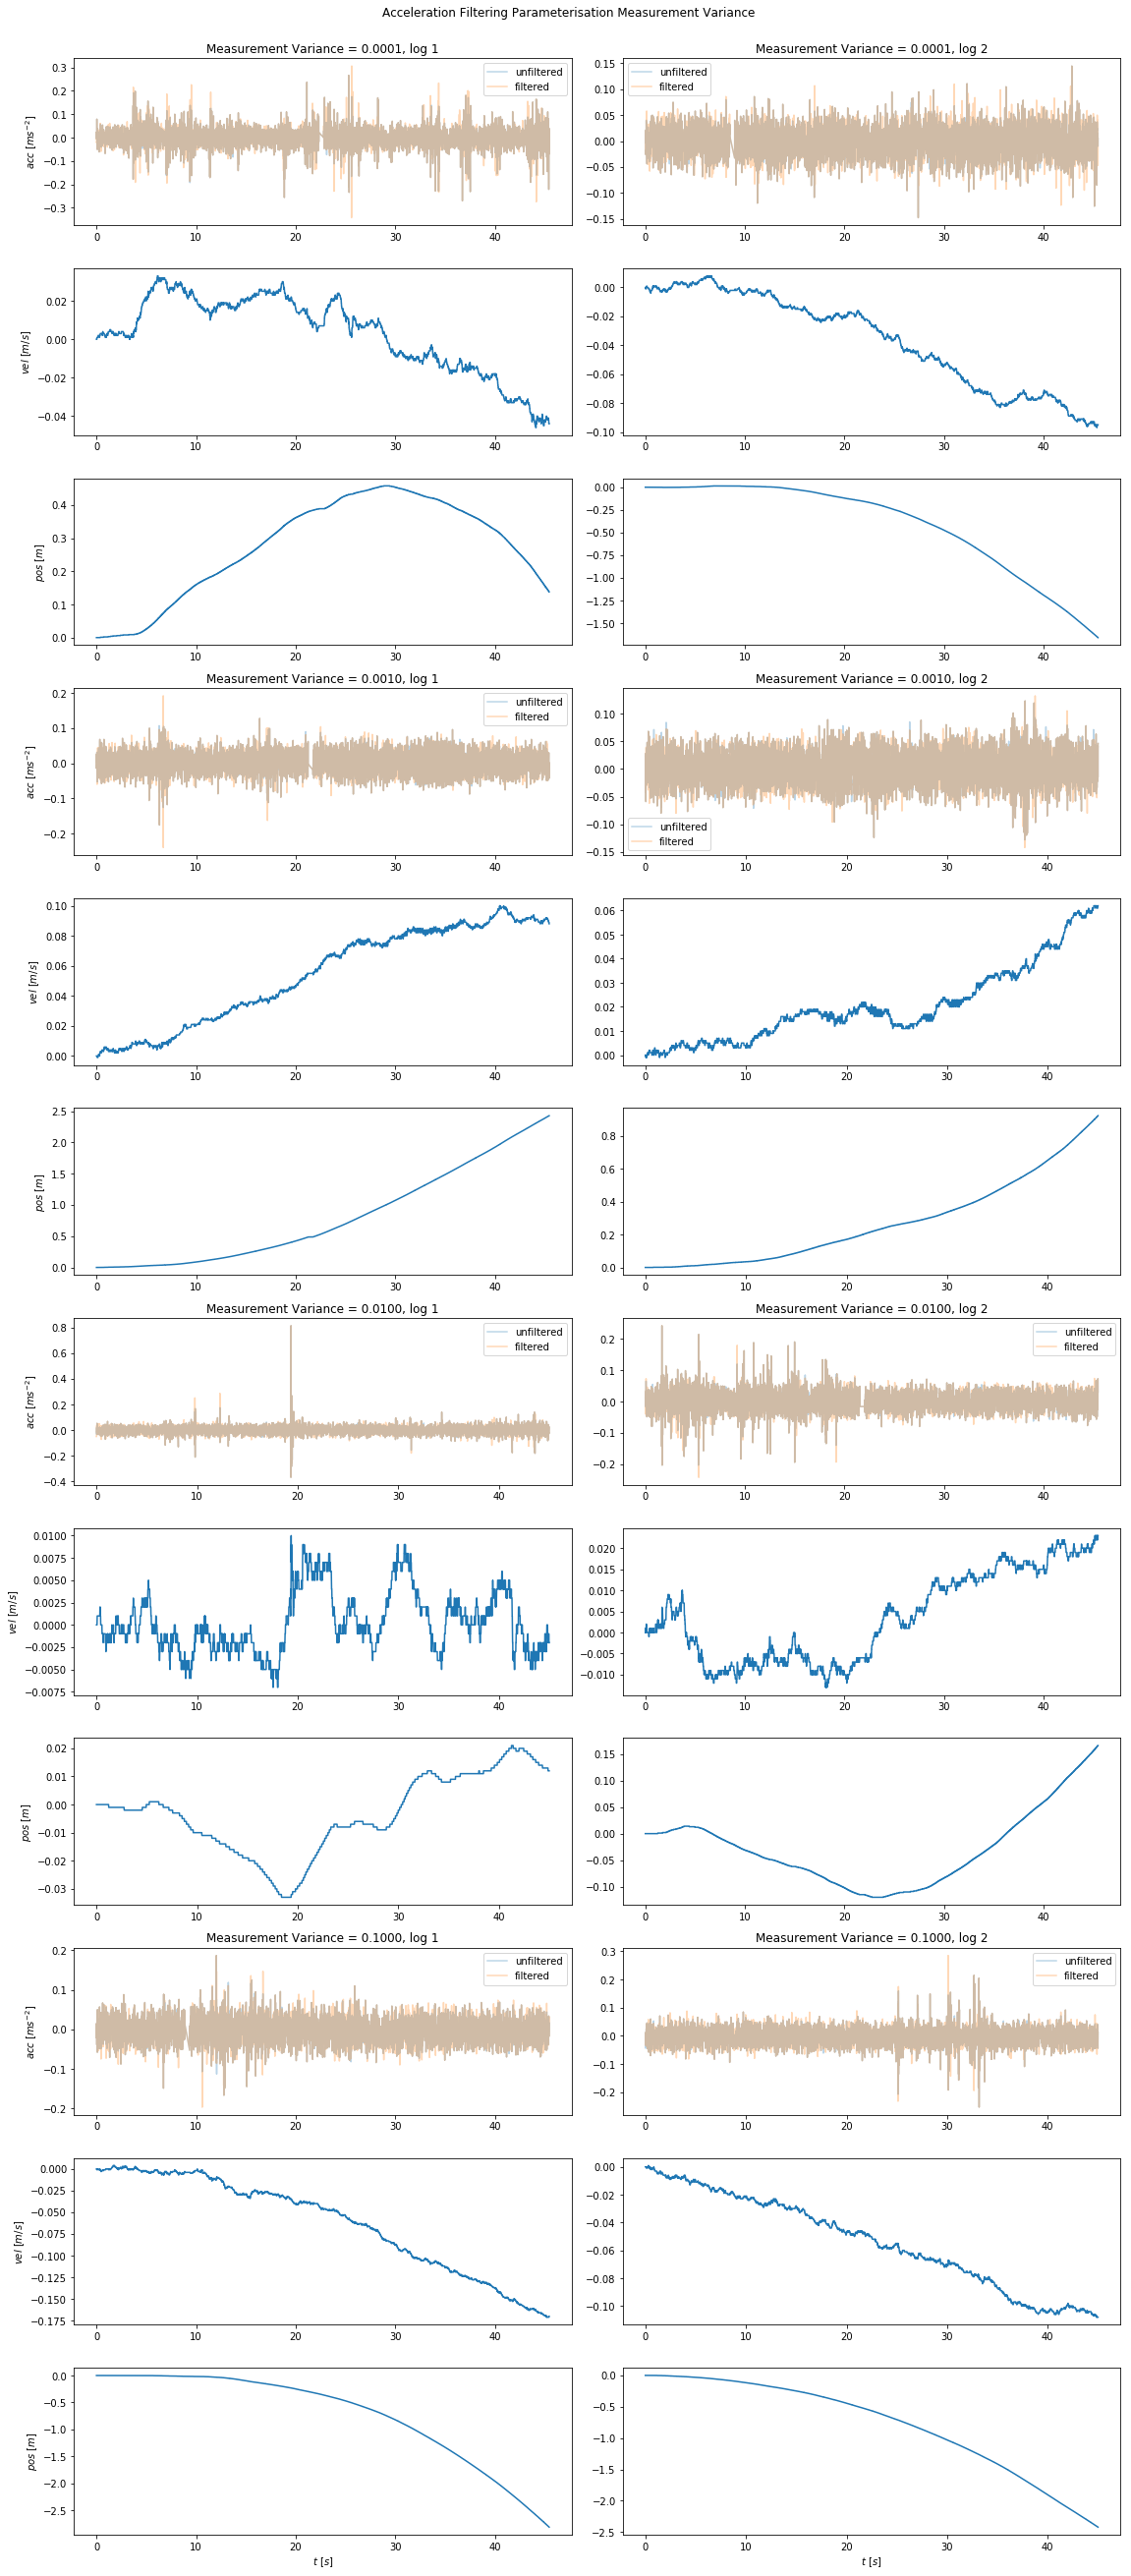

In [54]:
generate_plots(measurement_var_dicts, "Measurement Variance")